In [14]:
import pandas as pd
import os
import joblib
import shutil
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data from CSV files
home_price_index = pd.read_csv('CSUSHPISA.csv', parse_dates=['DATE'], index_col='DATE')
interest_rate = pd.read_csv('MORTGAGE30US.csv', parse_dates=['DATE'], index_col='DATE')
unemployment_rate = pd.read_csv('UNRATE.csv', parse_dates=['DATE'], index_col='DATE')
income = pd.read_csv('MEHOINUSA672N.csv', parse_dates=['DATE'], index_col='DATE')
housing_starts = pd.read_csv('HOUST.csv', parse_dates=['DATE'], index_col='DATE')
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['DATE'], index_col='DATE')

# Standardize date range to the common range across all datasets
start_date = max(home_price_index.index.min(), interest_rate.index.min(), unemployment_rate.index.min(), income.index.min(), housing_starts.index.min(), cpi.index.min())
end_date = min(home_price_index.index.max(), interest_rate.index.max(), unemployment_rate.index.max(), income.index.max(), housing_starts.index.max(), cpi.index.max())

# Resample to monthly frequency and forward-fill, aligning all data to the same date range
home_price_index = home_price_index[start_date:end_date].resample('M').ffill()
interest_rate = interest_rate[start_date:end_date].resample('M').ffill()
unemployment_rate = unemployment_rate[start_date:end_date].resample('M').ffill()
income = income[start_date:end_date].resample('M').ffill()
housing_starts = housing_starts[start_date:end_date].resample('M').ffill()
cpi = cpi[start_date:end_date].resample('M').ffill()

# Merge all data into a single DataFrame
data = pd.concat([home_price_index, interest_rate, unemployment_rate, income, housing_starts, cpi], axis=1)
data.columns = ['HomePriceIndex', 'InterestRate', 'UnemploymentRate', 'MedianHouseholdIncome', 'HousingStarts', 'CPI']

# Drop any remaining NaN values
data.dropna(inplace=True)

# Check the data
print(data.head())

# Save the data to a CSV file
data.to_csv('home_price_data.csv')

            HomePriceIndex  InterestRate  UnemploymentRate  \
DATE                                                         
1987-01-31          63.965          9.08               6.6   
1987-02-28          64.425          9.07               6.6   
1987-03-31          64.735          9.03               6.6   
1987-04-30          65.132         10.37               6.3   
1987-05-31          65.564         10.70               6.3   

            MedianHouseholdIncome  HousingStarts    CPI  
DATE                                                     
1987-01-31                  60760         1774.0  111.4  
1987-02-28                  60760         1784.0  111.8  
1987-03-31                  60760         1726.0  112.2  
1987-04-30                  60760         1614.0  112.7  
1987-05-31                  60760         1628.0  113.0  


In [15]:
data.shape

(420, 6)

Linear Regression MSE: 131.8821780317511
Random Forest MSE: 2.28557225329289
CPI                      0.921755
MedianHouseholdIncome    0.061934
UnemploymentRate         0.011456
InterestRate             0.002570
HousingStarts            0.002285
dtype: float64


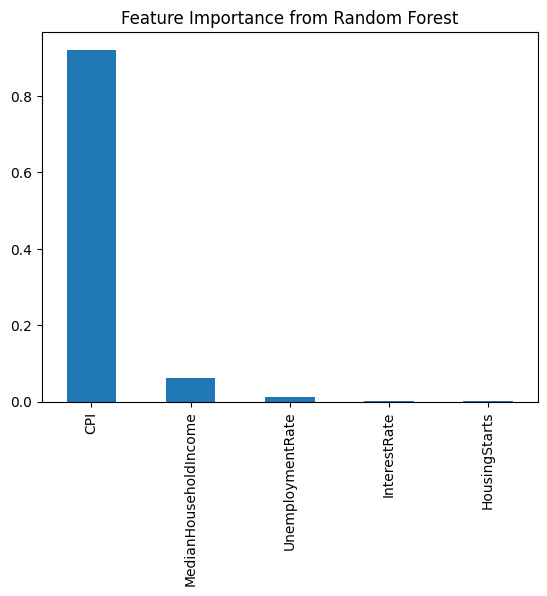

'/content/home_price_analysis.zip'

In [16]:
X = data.drop(columns=['HomePriceIndex'])
y = data['HomePriceIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr}')

# Random Forest Regressor Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

# Feature importance from Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

# Plotting feature importance
feature_importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.show()

# Save models and results
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
feature_importance.to_csv('feature_importance.csv')

# Saving the model evaluation results
with open('model_evaluation.txt', 'w') as f:
    f.write(f'Linear Regression MSE: {mse_lr}\n')
    f.write(f'Random Forest MSE: {mse_rf}\n')

# Creating a directory to store all outputs
output_dir = 'home_price_analysis'
os.makedirs(output_dir, exist_ok=True)

# Moving files to the output directory
shutil.move('home_price_data.csv', os.path.join(output_dir, 'home_price_data.csv'))
shutil.move('linear_regression_model.pkl', os.path.join(output_dir, 'linear_regression_model.pkl'))
shutil.move('random_forest_model.pkl', os.path.join(output_dir, 'random_forest_model.pkl'))
shutil.move('feature_importance.csv', os.path.join(output_dir, 'feature_importance.csv'))
shutil.move('model_evaluation.txt', os.path.join(output_dir, 'model_evaluation.txt'))

# Creating a zip file of the output directory
shutil.make_archive(output_dir, 'zip', output_dir)

In [17]:
from sklearn.metrics import r2_score

# Calculate R-squared for Linear Regression model
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression R-squared: {r2_lr}')

# Calculate R-squared for Random Forest model
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest R-squared: {r2_rf}')


Linear Regression R-squared: 0.9574597518046982
Random Forest R-squared: 0.9992627600455616
